In [4]:
%matplotlib inline
from matplotlib import pyplot
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.affinity import scale
from shapely.affinity import translate
import numpy as np

from weavingspace import TileUnit
from weavingspace import Tiling

In [5]:
ak = gpd.read_file("data/imd-auckland-2018.gpkg")

# Wobbly-sided 'Escherian' squares
This is actually hard to make by hand. Some careful coding would be needed to make a parameterisable function to generate such tiles.

In [6]:
spacing = 400
unit = TileUnit(crs = 2193, spacing = spacing)

In [7]:
d = spacing / 2

x1 = np.linspace(-d, d, 50, endpoint = True)
y1 = [-d - d/2 * np.sin(x/d * np.pi) for x in x1]
edge1 = [Point(x, y) for x, y in zip(x1, y1)]
edge3 = [translate(p, 0, 2*d) for p in edge1]
edge3.reverse()

y2 = x1.copy()
x2 = [ d + d/2 * np.sin(y/d * np.pi) for y in y2]
edge2 = [Point(x, y) for x, y in zip(x2, y2)]
edge4 = [translate(p, -2*d, 0) for p in edge2]
edge4.reverse()

tile1 = translate(
    scale(Polygon(edge1 + edge2 + edge3 + edge4), 0.5, 0.5), -d/2, -d/2)
tile2 = translate(tile1, d, 0)
tile3 = translate(tile2, 0, d)
tile4 = translate(tile3, -d, 0)

tile = gpd.GeoDataFrame(
    geometry = gpd.GeoSeries([tile1, tile2, tile3, tile4]),
    # .scale(0.95, 0.95, origin = (0, 0)),
    data = {"tile_id": list("abcd")}, crs = ak.crs)

<Axes: >

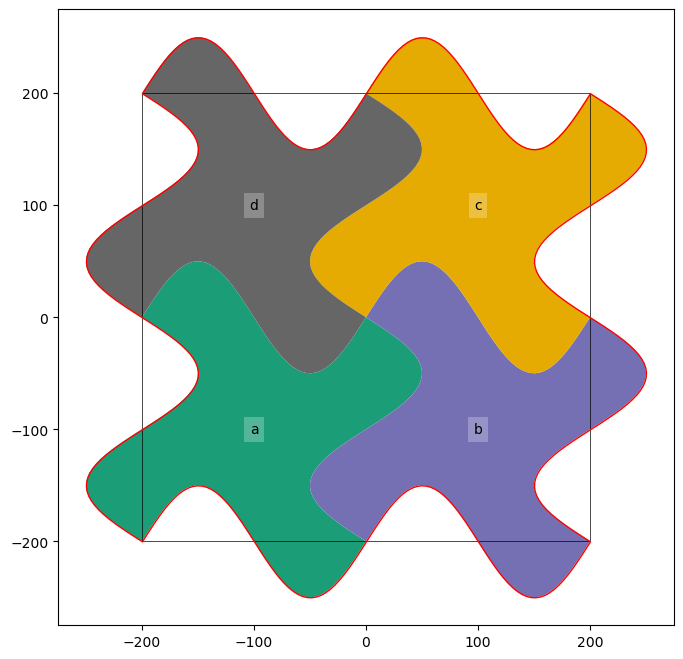

In [8]:
unit.tiles = tile
unit.regularised_prototile = \
    gpd.GeoSeries(unit.tiles.geometry.buffer(
        1e-3, join_style = 2).unary_union.buffer(-1e-3))
unit.plot()

In [9]:
tiling = Tiling(unit, ak, prototile_margin = 5)

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/constructive.py:995: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/constructive.py:995: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


In [10]:
t30 = tiling.get_tiled_map(rotation = 30)

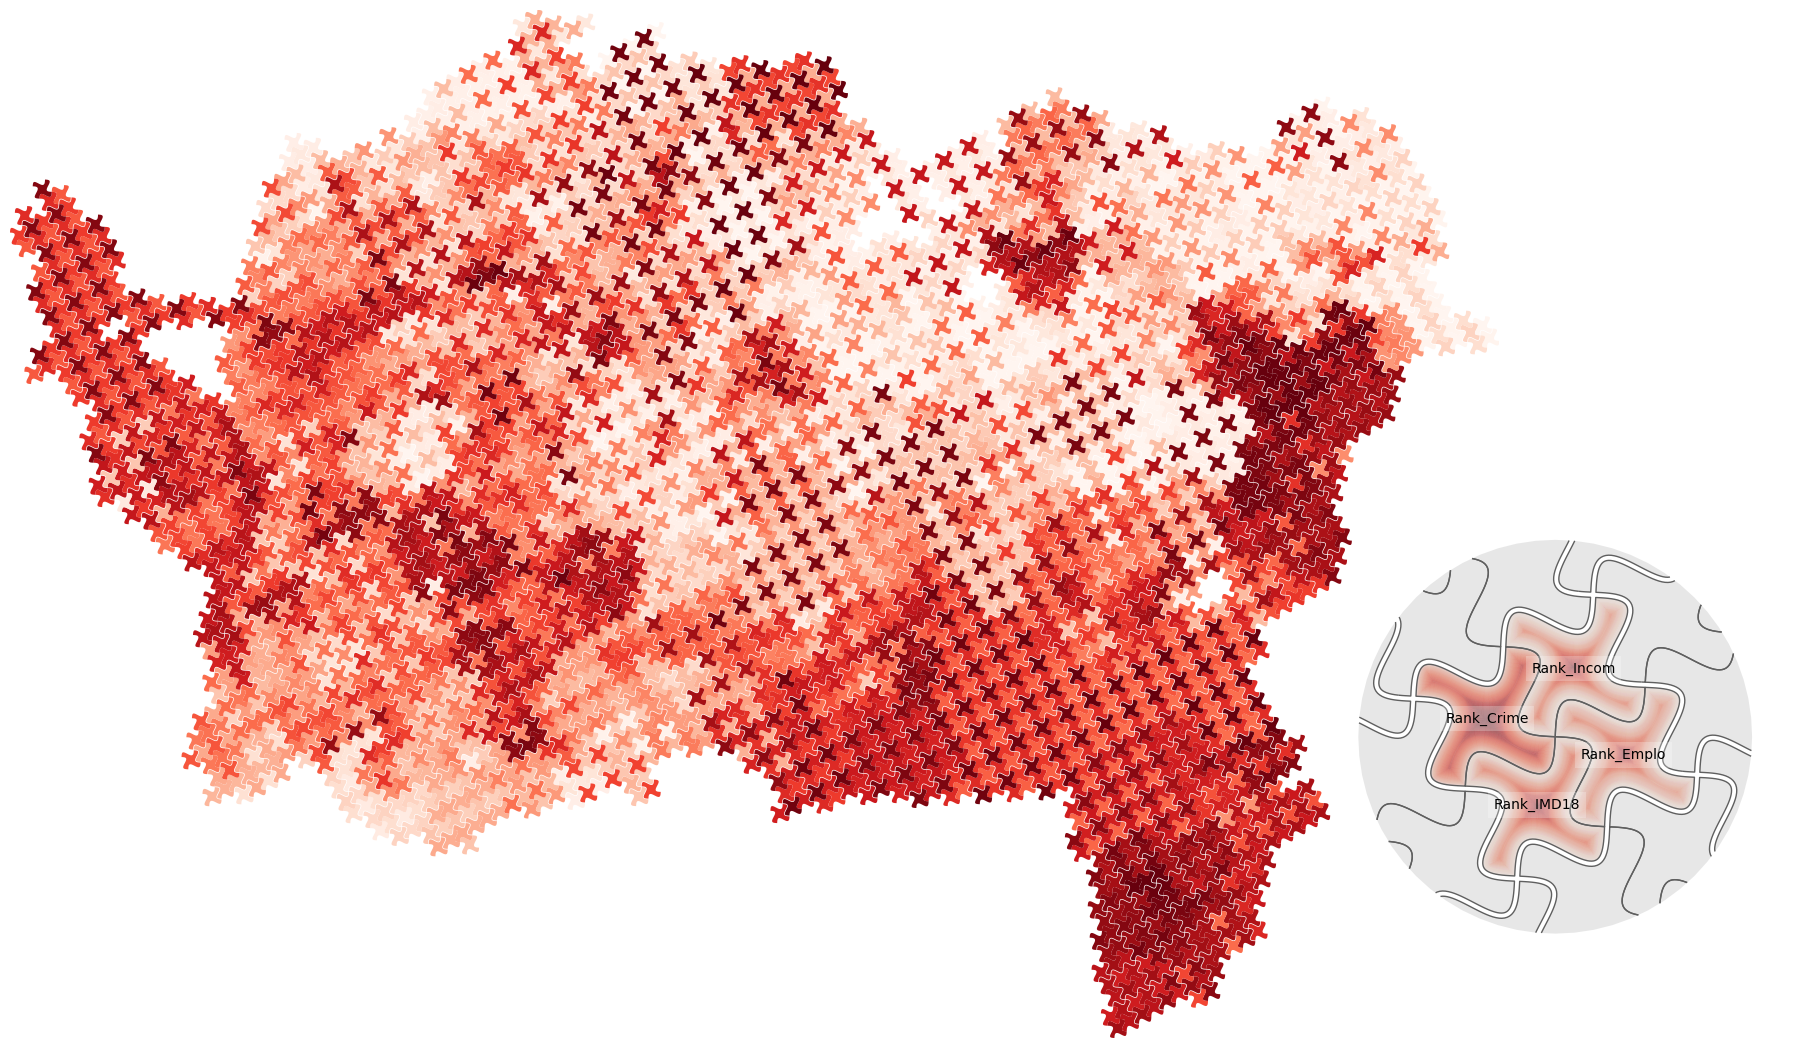

In [11]:
t30.variables = dict(zip(list("abcd"), 
                         [x for x in ak if "Rank" in x]))
t30.colourmaps = dict(zip(t30.variables.values(), 
                          ("Reds", "Reds", "Reds", "Reds")))
t30.dpi = 90
fig = t30.render(legend_zoom = .8, use_ellipse = True, 
                 legend_dx = -0.1, legend_dy = -0.475)

This seems to work well showing up constrasting variables... and surprisingly it seems to be possible to tell that it's the same variable contrasting in most cases, due to the grid locations.